In [1]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
from models.arima_forecasts import ARIMA_forecast, find_arima_spec
from models.random_walk import random_walk_forecast
from models.ann import ANN_forecast
from helper_functions import compute_rmse, load_monthly_baci_data, load_daily_baci_data, load_weekly_baci_data, load_daily_exog_data, load_weekly_exog_data, load_monthly_exog_data, load_monthly_exog_spot_data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning
from models.ann import ANN_diff_forecast

# Suppress all warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=ValueWarning)

def ARIMA_vs_RW_vs_ANN(data, 
                       train_ratio=0.8, 
                       steps_ahead=1, 
                       n_forecasts=1, 
                       plot=False, 
                       res=15, 
                       arima_spec=(1, 1, 2), 
                       ann_spec=(2, 2),
                       epochs=10, 
                       plot_all=True,
                       arima_f=True,
                       ann_f=True,
                       comb_f=True,
                       arimax_f=True,
                       annx_f=False,
                       exog=None):


    def plot_forecast(arima_fitted_df, 
                      arima_forecast_df, 
                      rw_forecast_df,
                      ann_fitted_df,
                      ann_forecast_df,
                      train_df,
                      test_df,
                      res=15):
        true_values = pd.concat([train, test])

        # Plot
        plt.figure(figsize=(15,7))

        plt.plot(true_values.index[-res - steps_ahead:], true_values[-res - steps_ahead:].values, color="blue", label='observed')
        plt.plot(arima_fitted_df.index[-res:], arima_fitted_df[-res:].values, color='green', label='ARIMA fitted')
        plt.plot(ann_fitted_df.index[-res:], ann_fitted_df[-res:].values, color='red', label='ANN fitted')
        
        
        # Rename columns of train_df.iloc[-1] to match rw_forecast_df's columns
        # Convert the last value of train_df to a dataframe with the same column name as rw_forecast_df
        renamed_row = pd.DataFrame([arima_fitted_df.values[-1]], columns=arima_forecast_df.columns, index=[arima_fitted_df.index[-1]])
        arima_forecast_df_merged = pd.concat([renamed_row, arima_forecast_df])
    
        renamed_row = pd.DataFrame([ann_fitted_df.values[-1]], columns=ann_forecast_df.columns, index=[ann_fitted_df.index[-1]])
        ann_forecast_df_merged = pd.concat([renamed_row, ann_forecast_df])
      
        renamed_row = pd.DataFrame([train_df.iloc[-1]], columns=rw_forecast_df.columns, index=[train_df.index[-1]])
        rw_forecast_df_merged = pd.concat([renamed_row, rw_forecast_df])


        plt.plot(arima_forecast_df_merged.index, arima_forecast_df_merged.values, color='green', label='ARIMA forecast', linestyle=":")
        plt.plot(rw_forecast_df_merged.index, rw_forecast_df_merged.values, color="purple", label="RW forecast", linestyle=":")
        plt.plot(ann_forecast_df_merged.index, ann_forecast_df_merged.values, color="red", label="ANN forecast", linestyle=":")

        plt.legend()
        plt.show()
        print(f"ARIMA MSE: {compute_rmse(test, arima_forecast_df)}")
        print(f"RW MSE: {compute_rmse(test, rw_forecast_df)}")
        print(f"ANN MSE: {compute_rmse(test, ann_forecast_df)}")




    train_size = int(train_ratio * len(data))
    arima_rmses, arimax_rmses, rw_rmses, ann_rmses, annx_rmses, comb_rmses = [], [], [], [], [], []
    
    # Initialize empty DataFrames with 'Date' as the index
    columns = ['Forecast']
    first_train_size = train_size
    arima_all_forecasts_df = arimax_all_forecasts_df = rw_all_forecasts_df = ann_all_forecasts_df = annx_all_forecasts_df = comb_all_forecasts_df = pd.DataFrame(columns=columns).set_index(pd.DatetimeIndex([], name='Date'))
    
    for _ in range(n_forecasts):
        print("Forecast number " + str(_ + 1))
        train = data["CLOSE"].iloc[:train_size]
        test = data["CLOSE"].iloc[train_size:train_size + steps_ahead]
        exog_train = exog.iloc[:train_size]
        exog_test = exog.iloc[train_size: train_size + steps_ahead]

        # Random Walk forecast
        rw_forecast_df = random_walk_forecast(train, test)
        rw_rmse = compute_rmse(test, rw_forecast_df)
        rw_rmses.append(rw_rmse)
        rw_all_forecasts_df = pd.concat([rw_all_forecasts_df, rw_forecast_df])


        if arima_f:
            # ARIMA forecast
            arima_fitted_df, arima_forecast_df, arima_model = ARIMA_forecast(train, 
                                                                            test, 
                                                                            steps_ahead, 
                                                                            p=arima_spec[0], 
                                                                            i=arima_spec[1], 
                                                                            q=arima_spec[2],
                                                                            plot=False,
                                                                            exog=None)
            arima_rmse = compute_rmse(test, arima_forecast_df)
            arima_rmses.append(arima_rmse)
            arima_all_forecasts_df = pd.concat([arima_all_forecasts_df, arima_forecast_df])
        if arimax_f:
            # ARIMAX forecast
            arimax_fitted_df, arimax_forecast_df, arimax_model = ARIMA_forecast(train, 
                                                                            test, 
                                                                            steps_ahead, 
                                                                            p=arima_spec[0], 
                                                                            i=arima_spec[1], 
                                                                            q=arima_spec[2],
                                                                            plot=False,
                                                                            exog=exog)
            #print(arima_forecast_df.values)
            arimax_rmse = compute_rmse(test, arimax_forecast_df)
            arimax_rmses.append(arimax_rmse)
            arimax_all_forecasts_df = pd.concat([arimax_all_forecasts_df, arimax_forecast_df])


        if ann_f:
            # ANN forecast
            ann_fitted_df, ann_forecast_df = ANN_diff_forecast(train=train, 
                                                        test=test, 
                                                        steps_ahead=steps_ahead,
                                                        lookback=ann_spec[0],
                                                        hidden_units=ann_spec[1],
                                                        epochs=epochs)
            ann_rmse = compute_rmse(test, ann_forecast_df)
            ann_rmses.append(ann_rmse)
            ann_all_forecasts_df = pd.concat([ann_all_forecasts_df, ann_forecast_df])
        
        if annx_f:
             # ANNX forecast
            annx_fitted_df, annx_forecast_df = ANN_diff_forecast(train=train, 
                                                        test=test, 
                                                        steps_ahead=steps_ahead,
                                                        lookback=ann_spec[0],
                                                        hidden_units=ann_spec[1],
                                                        exog_train=exog_train,
                                                        exog_test=exog_test,
                                                        epochs=epochs)
            annx_rmse = compute_rmse(test, annx_forecast_df)
            annx_rmses.append(annx_rmse)
            annx_all_forecasts_df = pd.concat([annx_all_forecasts_df, annx_forecast_df])

        if comb_f:
            # Combination forecast
            comb_forecast_df = pd.DataFrame()
            comb_forecast_df["Forecast"] = (ann_forecast_df["Forecast"] + arima_forecast_df["Forecast"]) / 2
            comb_rmse = compute_rmse(test, comb_forecast_df)

            comb_rmses.append(comb_rmse)
            comb_all_forecasts_df = pd.concat([comb_all_forecasts_df, comb_forecast_df])

        train_size += steps_ahead

        if plot:
            plot_forecast(arima_fitted_df=arima_fitted_df,
                          arima_forecast_df=arima_forecast_df,
                          rw_forecast_df=rw_forecast_df,
                          ann_fitted_df=ann_fitted_df,
                          ann_forecast_df=ann_forecast_df,
                          train_df=train,
                          test_df=test,
                          res=res)
    if plot_all:
        plt.gca().set_prop_cycle(None)  # Reset color cycle
        plt.plot(data.index[first_train_size:train_size + steps_ahead - 1], data[first_train_size:train_size + steps_ahead - 1].values, color="blue", label='observed')
        plt.gca().set_prop_cycle(None)  # Reset color cycle
        plt.plot(rw_all_forecasts_df.index, rw_all_forecasts_df.values, color='purple', label='RW forecast', linestyle=":")

        if arima_f:
            plt.plot(arima_all_forecasts_df.index, arima_all_forecasts_df.values, color='green', label='ARIMA forecast', linestyle=":")
        if ann_f:
            plt.plot(ann_all_forecasts_df.index, ann_all_forecasts_df.values, color='red', label='ANN forecast', linestyle=":")
        if comb_f:
            plt.plot(comb_all_forecasts_df.index, comb_all_forecasts_df.values, color='black', label='ANN/ARIMA combination', linestyle=":")
        if arimax_f:
            plt.plot(arimax_all_forecasts_df.index, arimax_all_forecasts_df.values, color='brown', label='ARIMAX forecast', linestyle=":")
        if annx_f:
            plt.plot(annx_all_forecasts_df.index, annx_all_forecasts_df.values, color='pink', label='ANNX forecast', linestyle=":")


        # Rotate x-axis labels for better clarity
        plt.xticks(rotation=45)

        # Optional: Use fewer date ticks on the x-axis
        #import matplotlib.dates as mdates
        #plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))  # Every week

        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys())  # Display unique labels only

        plt.tight_layout()  # Adjust the layout for better display
        plt.show()

        


    return arima_rmses, rw_rmses, ann_rmses, comb_rmses, arimax_rmses, annx_rmses

In [2]:
data_freq = "monthly"
exog_inc = True
if data_freq == "daily":
    df = load_daily_baci_data()
    if exog_inc:
        exog = load_daily_exog_data()
elif data_freq == "weekly":
    df = load_weekly_baci_data()
    if exog_inc:
        exog = load_weekly_exog_data()
else:
    df = load_monthly_baci_data()
    if exog_inc:
        exog = load_monthly_exog_spot_data()
        


 ADF p-value:  0.04791017854748517
ADF p-value:  1.4547341380228626e-20
ADF p-value:  7.417121481536125e-10
     Phillips-Perron Test (Z-tau)    
Test Statistic                 -3.571
P-value                         0.006
Lags                               16
-------------------------------------

Trend: Constant
Critical Values: -3.45 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
     Phillips-Perron Test (Z-tau)    
Test Statistic                -17.265
P-value                         0.000
Lags                               16
-------------------------------------

Trend: Constant
Critical Values: -3.45 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
KPSS Statistic: 0.4431853701157277
P-value: 0.058540788743220835
Num Lags: 10
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Ser

/Users/mariusbolstad/VSCode/project-thesis/models/arima_forecasts.py:225: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistic, p_value, n_lags, critical_values = kpss(values.diff().dropna(), regression='c')


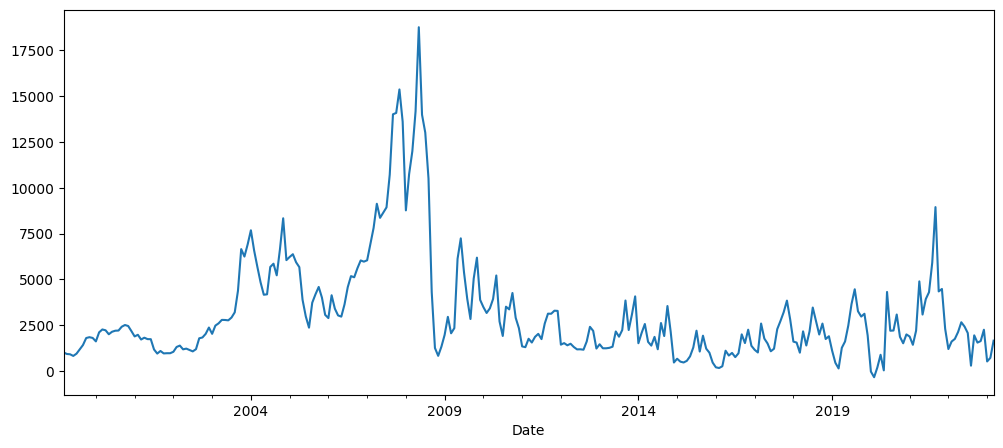

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.63 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4896.516, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4898.378, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4898.392, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4894.518, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4894.734, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.840 seconds
            IRON_CLOSE  COAL_CLOSE
Date                              
1999-03-31        1730        2505
1999-04-30        1730        2505
1999-05-31        1730        2505
1999-06-30        1730        2525
1999-07-31        1730        2378
            CLOSE
Date             
1999-03-31   1023
1999-04-30    940
1999-05-31    922
1999-06-30    833
1999-07-31    956


In [3]:

if exog_inc:
    # Inner join both dataframes on their index to ensure they have the same timestamp
    result = df.join(exog, how='inner', lsuffix='_baci', rsuffix='_ironfut')

    # Split the result back into individual dataframes if needed
    df = result[['CLOSE']]
    exog = result[['IRON_CLOSE', "COAL_CLOSE"]]

    # Rename the columns of the individual dataframes to 'CLOSE'
    df = df.rename(columns={'CLOSE_baci': 'CLOSE'})


find_arima_spec(df)
print(exog.head())
print(df.head())


Forecast number 1
                               SARIMAX Results                                
Dep. Variable:                  CLOSE   No. Observations:                  419
Model:                 ARIMA(3, 1, 1)   Log Likelihood               -3094.776
Date:                Thu, 02 Nov 2023   AIC                           6199.553
Time:                        17:32:32   BIC                           6219.730
Sample:                    10-20-2013   HQIC                          6207.529
                         - 10-24-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8339      0.151      5.523      0.000       0.538       1.130
ar.L2         -0.1755      0.080     -2.196      0.028      -0.332      -0.019
ar.L3         -0.1704      0.055  

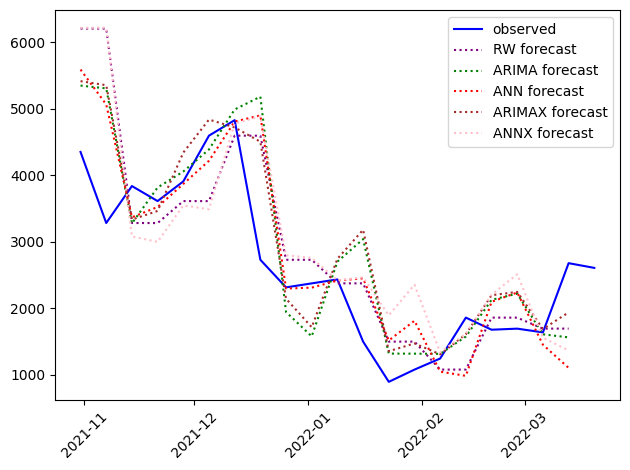

ARIMA RMSEs: 749.7561331652762
ARIMAX RMSEs: 699.0852830357579
Random Walk RMSEs: 792.8346390657881
ANN RMSEs: 732.1449997550969
ANNX RMSEs: 956.9205223404897
Combination RMSEs: N/A


In [11]:
train_ratio = 0.8
n_forecasts = 10
steps_ahead = 2
res = 200
arima_spec = (3, 1, 1)
ann_spec = (10, 10)
epochs = 50
plot = False
plot_all = True
res = 50
exog = exog
arima_f, arimax_f, ann_f, annx_f, comb_f = True, True, True, True, False
arima_rmses, rw_rmses, ann_rmses, comb_rmses, arimax_rmses, annx_rmses = ARIMA_vs_RW_vs_ANN(data=df, 
                                                                  res=res, 
                                                                  train_ratio=train_ratio,
                                                                  n_forecasts=n_forecasts,
                                                                  steps_ahead=steps_ahead,
                                                                  plot=False,
                                                                  arima_spec=arima_spec,
                                                                  ann_spec=ann_spec,
                                                                  epochs=epochs,
                                                                  exog=exog,
                                                                  arima_f=arima_f,
                                                                  arimax_f = arimax_f,
                                                                  ann_f=ann_f,
                                                                  annx_f=annx_f,
                                                                  comb_f=comb_f)
print(f"ARIMA RMSEs: {'N/A' if not arima_rmses else np.average(arima_rmses)}")
print(f"ARIMAX RMSEs: {'N/A' if not arima_rmses else np.average(arimax_rmses)}")
print(f"Random Walk RMSEs: {'N/A' if not rw_rmses else np.average(rw_rmses)}")
print(f"ANN RMSEs: {'N/A' if not ann_rmses else np.average(ann_rmses)}")
print(f"ANNX RMSEs: {'N/A' if not annx_rmses else np.average(annx_rmses)}")
print(f"Combination RMSEs: {'N/A' if not comb_rmses else np.average(comb_rmses)}")


# Open the file in write mode
with open('log.txt', 'a') as file:
    print("Monthly Forecast: Train ratio: " + str(train_ratio) + ". " + str(steps_ahead) + " step ahead. " + str(n_forecasts) + " forecasts", file=file)
    print(f"ARIMA RMSEs: {'N/A' if not arima_rmses else np.average(arima_rmses)}", file=file)
    print(f"ARIMAX RMSEs: {'N/A' if not arimax_rmses else np.average(arimax_rmses)}", file=file)
    print(f"Random Walk RMSEs: {'N/A' if not rw_rmses else np.average(rw_rmses)}", file=file)
    print(f"ANN RMSEs: {'N/A' if not ann_rmses else np.average(ann_rmses)}", file=file)
    print(f"ANNX RMSEs: {'N/A' if not annx_rmses else np.average(annx_rmses)}", file=file)
    print(f"Combination RMSEs: {'N/A' if not comb_rmses else np.average(comb_rmses)}", file=file)

